# 9. Mixture Models and EM

### *Table of Contents*

* 9.1 [K-means Clustering](#9.1-K-means-Clustering)
    * 9.1.1 [Image segmentation and compression](#9.1.1-Image-segmentation-and-compression)
* 9.2 [Mixtures of Gaussians](#9.2-Mixtures-of-Gaussians)
    * 9.2.1 [Maximum likelihood](#9.2.1-Maximum-likelihood)
    * 9.2.2 [EM for Gaussian mixtures](#9.2.2-EM-for-Gaussian-mixtures)
* 9.3 [An Alternative View of EM](#9.3-An-Alternative-View-of-EM)
* 9.4 [The EM Algorithm in General](#9.4-The-EM-Algorithm-in-General)

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Project
from prml.clustering import KMeans
from prml.datasets import load_old_faithful
from prml.distribution import MultivariateGaussianMixture

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide="ignore", invalid="ignore")

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%reload_ext autoreload
%autoreload 2

## 9.1 K-means Clustering

Consider the problem of identifying groups, or clusters, of data points in a multidimensional space. Suppose that we have a data set $\{x_1,\dots,x_N\}$. The goal is to partition the data set into $K$ clusters, for a given value of $K$. Intuitively, a cluster can be a group of data points whose inter-point distances are small compared to the distances to points outside the cluster.

We can formalize this notion by introducing a set of D-dimensional vectors $\boldsymbol\mu_k$. Each such vector is a prototype associated with the $k$th cluster, essentially representing the centres of the clusters. Then, the goal is then to find an assignment of data points to clusters, and a set of vectors $\boldsymbol\mu_k$, such that the sum of the squares of the distances of each data point to its closest vector $\boldsymbol\mu_k$ is a minimum.

We can then define an objective function, sometimes called a distortion measure, given by

$$
J = \sum_{n=1}^N\sum_{k=1}^K r_{nk}||\mathbf{x}_n - \boldsymbol\mu_k||_2^2
$$

where $r_{nk} \in \{0, 1\}$ are binary indicator variables, describing which of the $K$ clusters the data point $x_n$ is assigned. The objective function represents the sum of the squares of the distances of each data point to its assigned cluster center $\boldsymbol\mu_k$. Thus, the goal is to find values for the $\{r_{nk}\}$ and the ${\boldsymbol\mu_k}$ that minimize $J$.

**K-means algorithm:**
> This can be achieved using an iterative procedure involving two successive steps. In the first phase we minimize $J$ with respect to the $r_{nk}$, keeping the $\boldsymbol\mu_k$ fixed. In the second phase we minimize $J$ with respect to the $\boldsymbol\mu_k$, keeping $r_{nk}$ fixed. These two stages are then repeated until convergence. We shall see that these two stages of updating $r_{nk}$ and updating $\boldsymbol\mu_k$ correspond respectively to the E (expectation) and M (maximization) steps of the EM algorithm.

Consider the determination of the $r_{nk}$. Because $J$ is a linear function of $r_{nk}$, the optimization gives a closed form solution. The $n$ terms are independent and so we optimize for each $n$ separately by choosing $r_{nk}$ to be 1 for whichever value of $k$ gives the minimum value of $||\mathbf{x}_n - \boldsymbol\mu_k||_2^2$. In other words, we simply assign each data point to its closest cluster centre or more formally,

$$
r_{nk} = 
\begin{cases}
1 & \text{if} \; k = \text{argmin}_j ||\mathbf{x}_n - \boldsymbol\mu_j||_2^2 \\
0 & \text{otherwise}
\end{cases}
$$

Then, consider the optimization of $\boldsymbol\mu_k$, while keeping $r_{nk}$ fixed. The objective function is a quadratic function of $\boldsymbol\mu_k$, and it can be minimized by setting its
derivative with respect to $\boldsymbol\mu_k$ to zero giving,

$$
\begin{aligned}
& \frac{\partial J}{\partial\boldsymbol\mu_k} = \mathbf{0} \Leftrightarrow \\
& \frac{\partial}{\partial\boldsymbol\mu_k} \sum_{n=1}^N\sum_{k=1}^K r_{nk}||\mathbf{x}_n - \boldsymbol\mu_k||_2^2 = \mathbf{0} \Leftrightarrow \\
& 2 \sum_{n=1}^N r_{nk}(\mathbf{x}_n - \boldsymbol\mu_k) = \mathbf{0} \Leftrightarrow \\
& \sum_{n=1}^N r_{nk}\mathbf{x}_n - \sum_{n=1}^N r_{nk}\boldsymbol\mu_k = \mathbf{0} \Leftrightarrow \\
& \sum_{n=1}^N r_{nk}\mathbf{x}_n = \sum_{n=1}^N r_{nk}\boldsymbol\mu_k \Leftrightarrow \\
& \boldsymbol\mu_k = \frac{\sum_{n=1}^N r_{nk}\mathbf{x}_n}{\sum_{n=1}^N r_{nk}}
\end{aligned}
$$

The denominator is equal to the number of points assigned to cluster $k$, and thus, $\boldsymbol\mu_k$ equal to the mean of all of the data points $\mathbf{x}_n$ assigned to cluster $k$. For this reason, the procedure is known as the $K$-means algorithm.

> Because each phase reduces the value of the objective function, convergence of the algorithm is assured. However, keep in mind, that it may converge to a local rather than global minimum.

Below the $K$-means algorithm is applied on the Old Faithful data set:

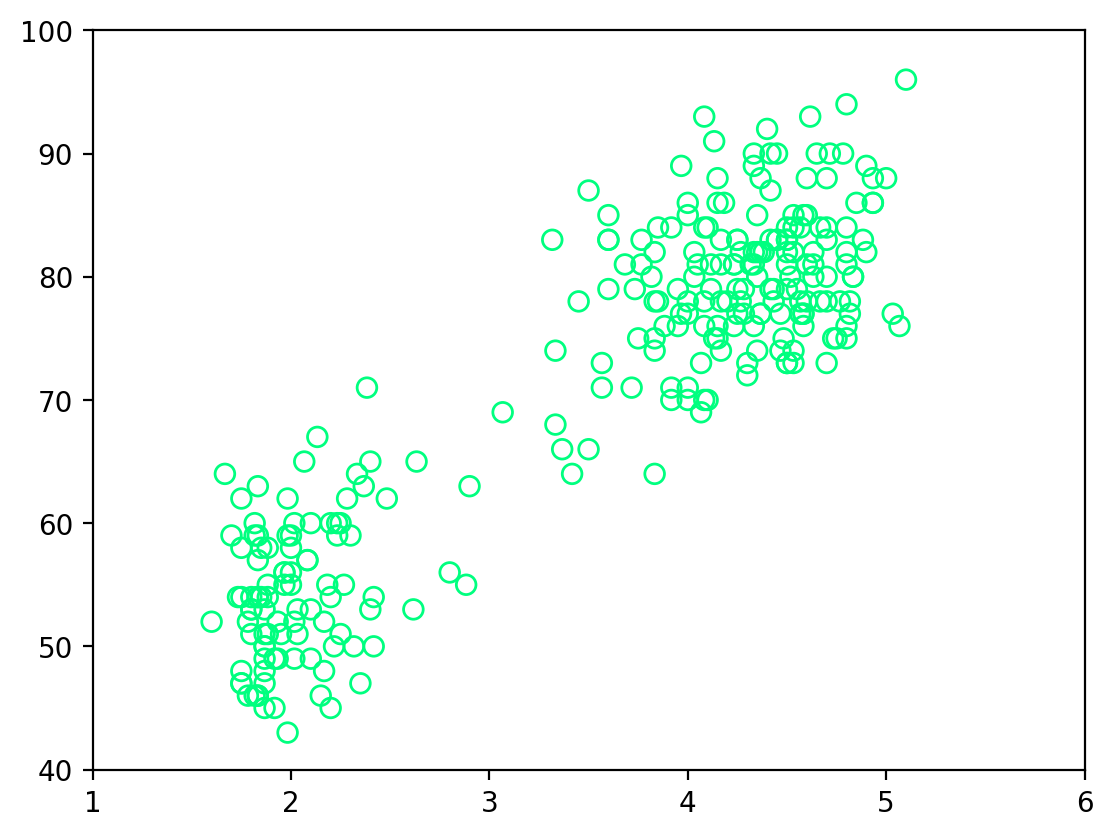

In [2]:
old_faithful = load_old_faithful()
plt.scatter(old_faithful[:, :1], old_faithful[:, 1:2], color="springgreen", facecolors="none", s=50)
plt.xlim(1, 6)
plt.ylim(40, 100)
plt.show()

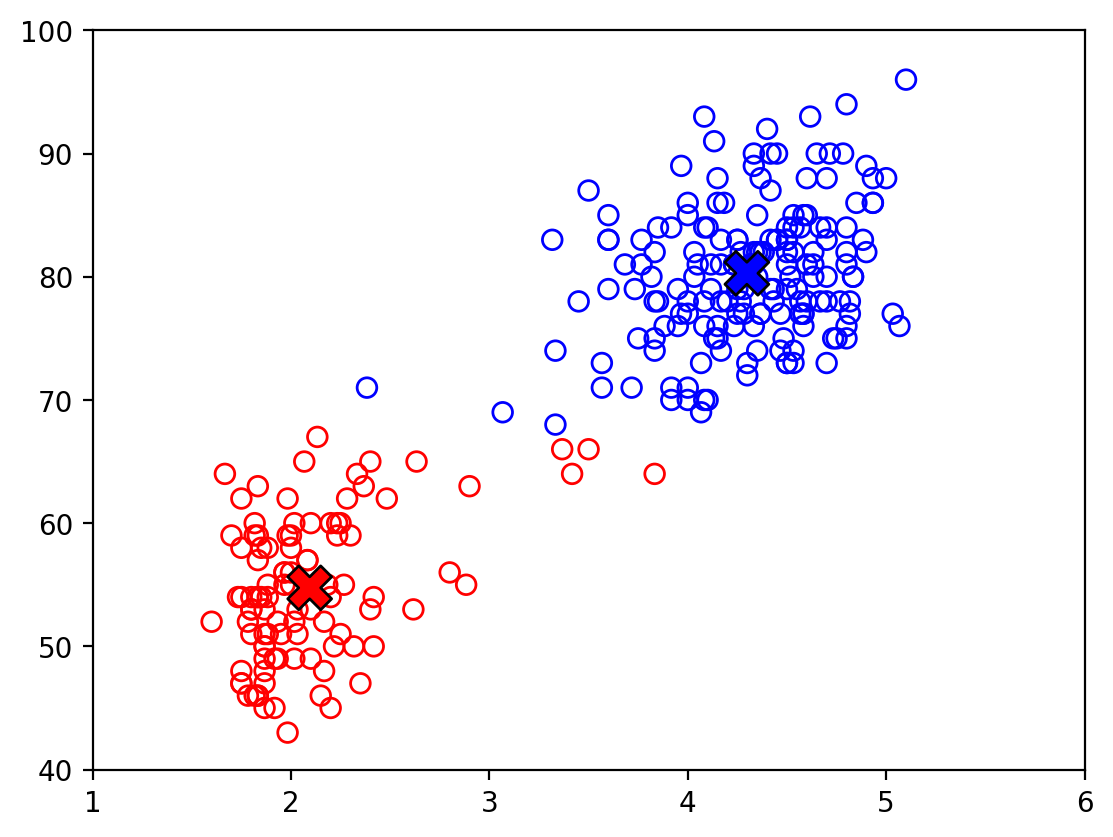

In [3]:
model = KMeans(2)
model.fit(old_faithful, n_iter=10)
classes = model.predict(old_faithful)

plt.scatter(
    old_faithful[:, :1],
    old_faithful[:, 1:2],
    edgecolors=np.where(classes == 0, "blue", "red").tolist(),
    facecolors="none",
    s=50,
)
plt.scatter(model.centers[:, 0], model.centers[:, 1], color=["blue", "red"], marker="X", s=250, edgecolors="black")
plt.xlim(1, 6)
plt.ylim(40, 100)
plt.show()

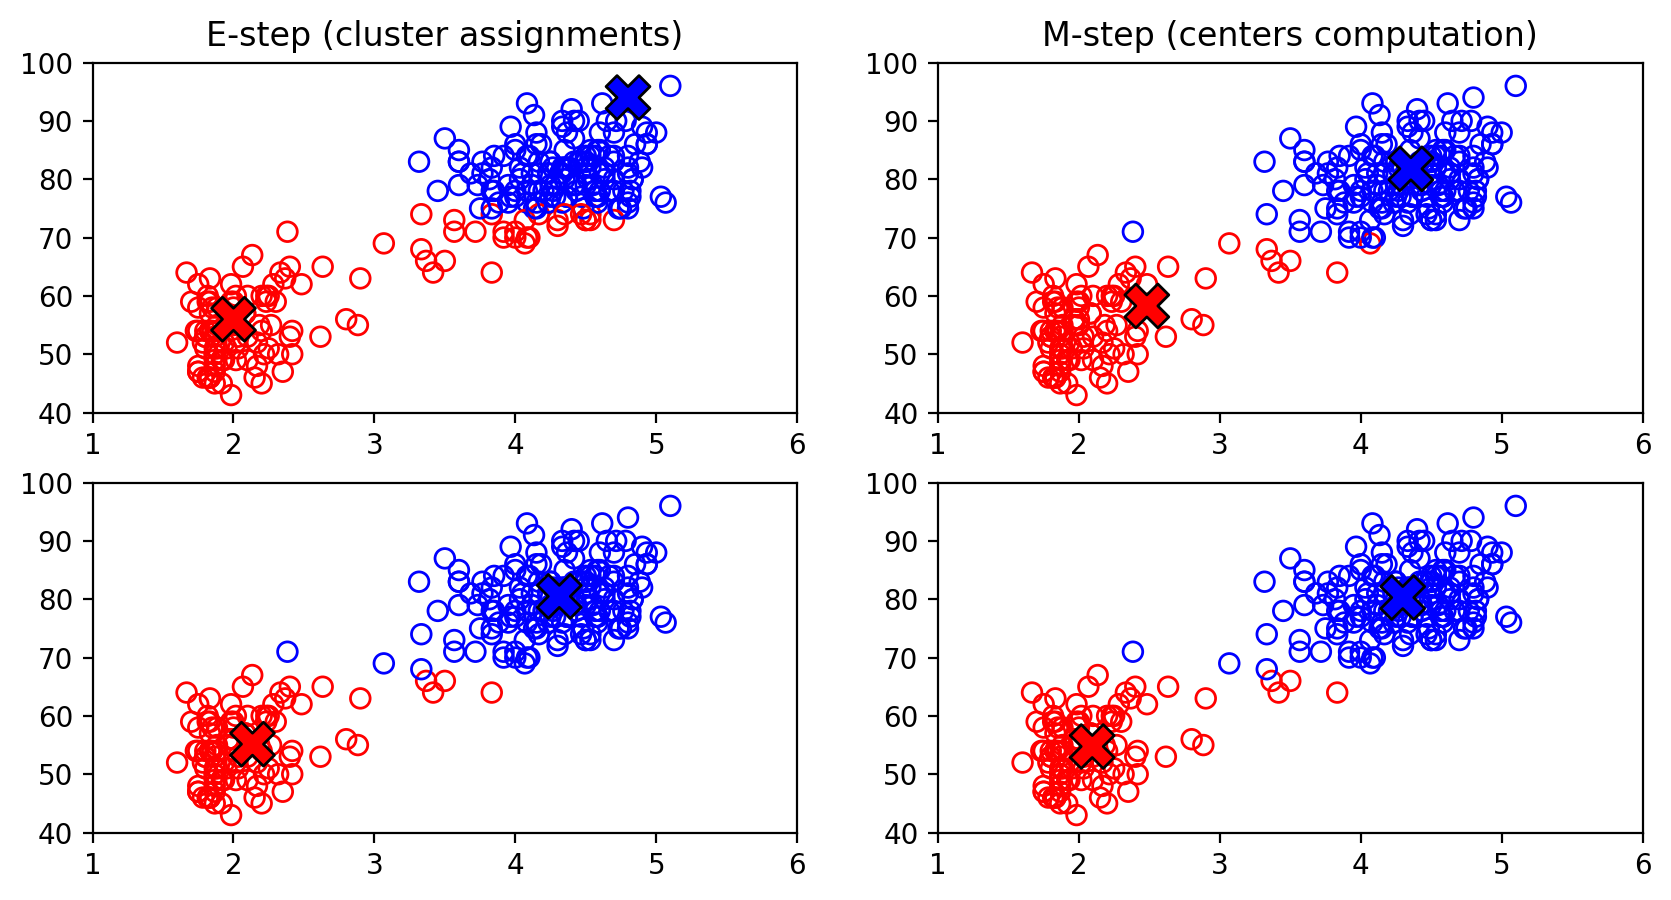

In [4]:
plt.figure(figsize=(10, 5))

# even are E-steps and odd are M-steps
for i, (centers, assignments) in enumerate(model.history):
    plt.subplot(2, 2, i + 1)
    plt.scatter(
        old_faithful[:, :1],
        old_faithful[:, 1:2],
        edgecolors=np.where(assignments == 0, "blue", "red").tolist(),
        facecolors="none",
        s=50,
    )
    plt.scatter(centers[:, 0], centers[:, 1], color=["blue", "red"], marker="X", s=250, edgecolors="black")
    plt.xlim(1, 6)
    plt.ylim(40, 100)

    if i == 0:
        plt.title("E-step (cluster assignments)")
    elif i == 1:
        plt.title("M-step (centers computation)")

The initial values for the cluster centres are choosen to be equal to a random subset of $K$ data points. It is also worth noting that the $K$-means algorithm itself is often used to initialize the parameters in a Gaussian mixture model before applying the EM algorithm.

> The implementation of the $K$-means algorithm as discussed here can be relatively slow, because for the E-step it is necessary to compute the Euclidean distance between every prototype vector and every data point. Several schemes have been proposed for speeding up $K$-means, some of which are based on precomputing a data structure (e.g., k-d tree) such that nearby points are in the same subtree. Other approaches make use of the triangle inequality for distances, thereby avoiding unnecessary distance calculations.

#### Online K-means

The batch version of K-means requires for the whole dataset to be used for updating the prototype vectors. We can also derive an on-line stochastic algorithm by applying the Robbins-Monro procedure to the problem of finding the roots of the regression function given by the derivatives of $J$ with respect to $\boldsymbol\mu_k$. Decomposing the batch objective function, we obtain,

$$
J_N = J_{N-1} + \sum_{k=1}^K r_{Nk}||\mathbf{x}_N - \boldsymbol\mu_k||_2^2
$$

Therefore, in the E-step, the $N$-th data point is still assigned to the closest center. Suppose that is $\boldsymbol\mu_m$. Thus, the expression $J_N$ becomes,

$$
J_N = J_{N-1} + ||\mathbf{x}_N - \boldsymbol\mu_m||_2^2
$$

For the M-step, setting the derivative of $J_N$ with respect to $\boldsymbol\mu_k$ equal to $\mathbf{0}$, gives,

$$
\begin{aligned}
\frac{\partial J}{\partial\boldsymbol\mu_k} = \mathbf{0} & \Leftrightarrow
\frac{\partial J_{N-1}}{\partial\boldsymbol\mu_k} + \frac{\partial ||\mathbf{x}_N - \boldsymbol\mu_m||_2^2}{\partial\boldsymbol\mu_k} = \mathbf{0} \\
& \overset{k=m}{\Leftrightarrow} \frac{\partial J_{N-1}}{\partial\boldsymbol\mu_m} + \frac{\partial ||\mathbf{x}_N - \boldsymbol\mu_m||_2^2}{\partial\boldsymbol\mu_m} = \mathbf{0} \\
& \Leftrightarrow 2 \sum_{n=1}^{N-1} r_{nm}(\mathbf{x}_n - \boldsymbol\mu_m) + 2(\mathbf{x}_N - \boldsymbol\mu_m) = \mathbf{0} \\
& \Leftrightarrow \sum_{n=1}^{N-1} r_{nm}(\mathbf{x}_n - \boldsymbol\mu_m) + \mathbf{x}_N - \boldsymbol\mu_m = \mathbf{0} \\
& \Leftrightarrow \sum_{n=1}^{N-1} r_{nm}\mathbf{x}_n - \sum_{n=1}^{N-1} r_{nm}\boldsymbol\mu_m + \mathbf{x}_N - \boldsymbol\mu_m = \mathbf{0} \\
& \Leftrightarrow \sum_{n=1}^{N-1} r_{nm}\mathbf{x}_n + \mathbf{x}_N = \sum_{n=1}^{N-1} r_{nm}\boldsymbol\mu_m + \boldsymbol\mu_m \\
& \Leftrightarrow \sum_{n=1}^{N-1} r_{nm}\mathbf{x}_n + \mathbf{x}_N = \boldsymbol\mu_m\Big(\sum_{n=1}^{N-1} r_{nm} + 1\Big) \\
& \Leftrightarrow \boldsymbol\mu_m = \frac{\sum_{n=1}^{N-1} r_{nm}\mathbf{x}_n + \mathbf{x}_N}{\sum_{n=1}^{N-1} r_{nm} + 1}
\end{aligned}
$$

Then, we may further decompose the update formula as follows,

$$
\begin{aligned}
\boldsymbol\mu_m^{(\tau)} &= \frac{\sum_{n=1}^{N-1} r_{nm}\mathbf{x}_n + \mathbf{x}_N}{\sum_{n=1}^{N-1} r_{nm} + 1} \\
&= \frac{
    \frac{\sum_{n=1}^{N-1} r_{nm}\mathbf{x}_n}{\sum_{n=1}^{N-1} r_{nm}} + \frac{\mathbf{x}_N}{\sum_{n=1}^{N-1} r_{nm}}
}{
    1 + \frac{1}{\sum_{n=1}^{N-1} r_{nm}}
} \\
&= \frac{
   \boldsymbol\mu_m^{(\tau-1)} + \frac{\mathbf{x}_N}{\sum_{n=1}^{N-1} r_{nm}}
}{
    1 + \frac{1}{\sum_{n=1}^{N-1} r_{nm}}
} \\
&= \boldsymbol\mu_m^{(\tau-1)} + 
\frac{
   \frac{\mathbf{x}_N}{\sum_{n=1}^{N-1} r_{nm}} - \frac{\boldsymbol\mu_m^{(\tau-1)}}{\sum_{n=1}^{N-1} r_{nm}}
}{
    1 + \frac{1}{\sum_{n=1}^{N-1} r_{nm}}
} \\
&= \boldsymbol\mu_m^{(\tau-1)} + 
\frac{
   \mathbf{x}_N - \boldsymbol\mu_m^{(\tau-1)}
}{
    1 + \frac{1}{\sum_{n=1}^{N-1} r_{nm}}
}
\end{aligned}
$$

This leads to a sequential update in which, for each data point $\mathbf{x}_n$ in turn, we update the nearest prototype $\boldsymbol\mu_k$ using,

$$
\boldsymbol\mu_k^{(\tau)} = \boldsymbol\mu_k^{(\tau-1)} + \eta_n\Big(\mathbf{x}_n - \boldsymbol\mu_k^{(\tau-1)}\Big)
$$

where $\eta_n$ is a learning rate parameter that decreases monotonically as more data points are accumulated.

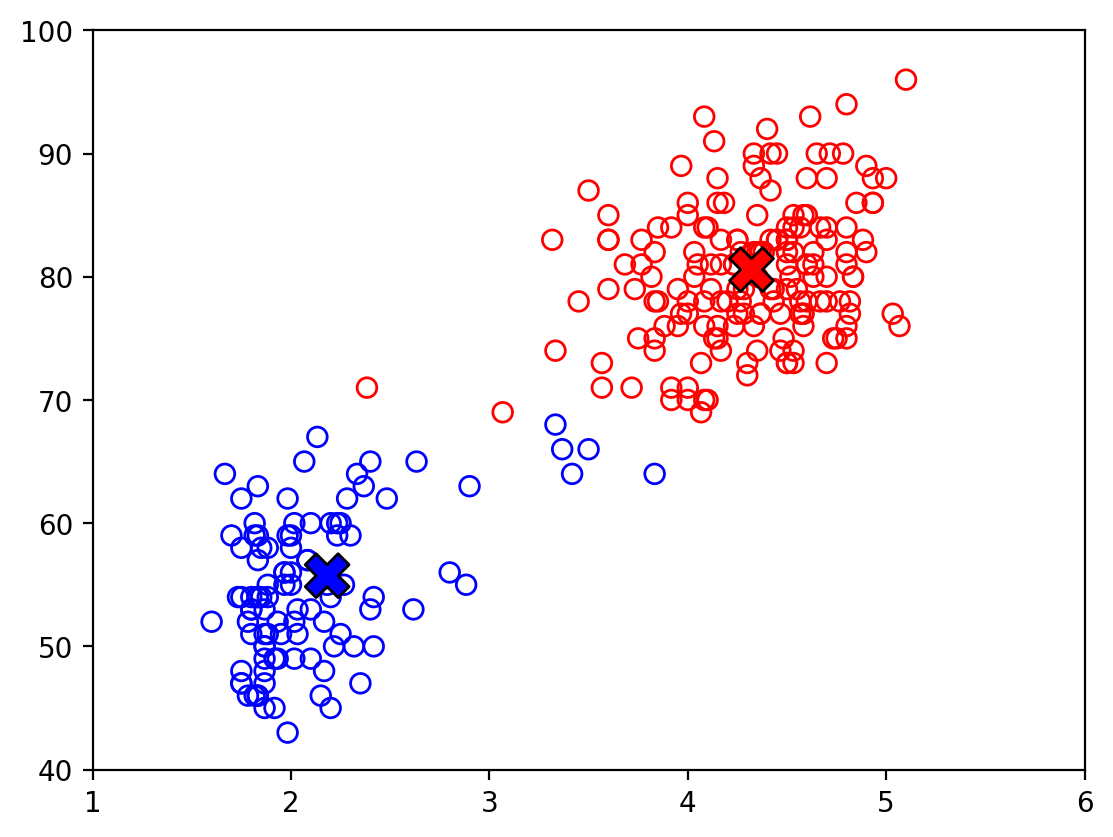

In [5]:
model = KMeans(2)

indices = list(range(len(old_faithful)))
np.random.shuffle(indices)
for i in indices:
    model.update(old_faithful[i, :])

classes = model.predict(old_faithful)

plt.scatter(
    old_faithful[:, :1],
    old_faithful[:, 1:2],
    edgecolors=np.where(classes == 0, "blue", "red").tolist(),
    facecolors="none",
    s=50,
)
plt.scatter(model.centers[:, 0], model.centers[:, 1], color=["blue", "red"], marker="X", s=250, edgecolors="black")
plt.xlim(1, 6)
plt.ylim(40, 100)
plt.show()

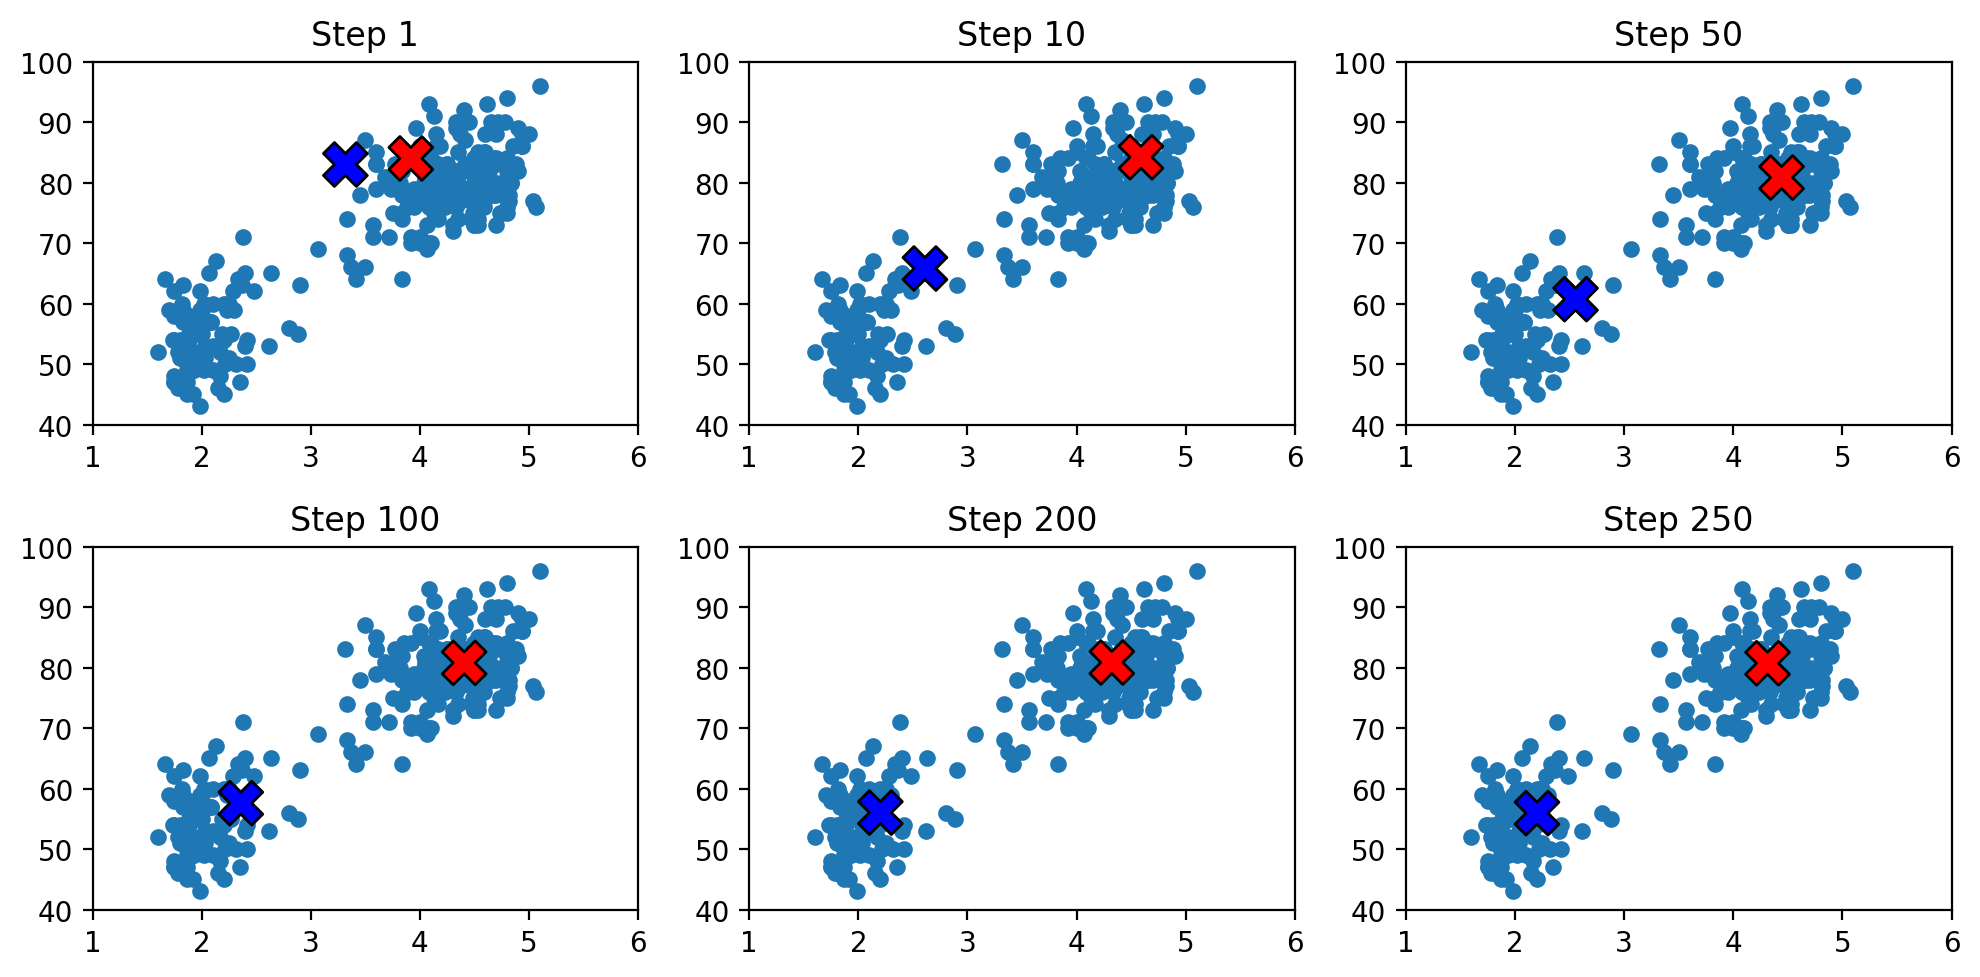

In [6]:
plt.figure(figsize=(10, 5))

plot_idx = 0
for i, (centers, assignments) in enumerate(model.history):
    if i in [1, 10, 50, 100, 200, 250]:
        plot_idx += 1
        plt.subplot(2, 3, plot_idx)
        plt.scatter(
            old_faithful[:, :1],
            old_faithful[:, 1:2],
            s=25,
        )
        plt.scatter(centers[:, 0], centers[:, 1], color=["blue", "red"], marker="X", s=250, edgecolors="black")
        plt.xlim(1, 6)
        plt.ylim(40, 100)
        plt.title(f"Step {i}")
        plt.tight_layout()

#### K-medoids

The K-means algorithm is typically based on the squared Euclidean distance for measuring the distance between a data point and a prototype vector. This limits the type of data variables that can be considered (is inappropriate for cases where some or all of the variables represent categorical labels for instance), but it also makes the determination of the cluster means non-robust to outliers. K-means algorithm can be generalized by introducing a more general dissimilarity measure $\mathcal{V}(\mathbf{x}, \mathbf{x}')$ and then minimizing the following distortion measure,

$$
\tilde{J} = \sum_{n=1}^N\sum_{m=1}^M r_{nk}\mathcal{V}(\mathbf{x}_n, \boldsymbol\mu_k )
$$

which gives the $K$-medoids algorithm. For a general choice of dissimilarity measure, the M step is potentially more complex than for $K$-means, and so it is common to restrict each cluster prototype to be equal to one of the data vectors assigned to that cluster. Thus, the M step involves, for each cluster $k$, a discrete search over the $Nk$ points assigned to that
cluster, which requires $O(N^2k)$ evaluations.

> Note that the $K$-means algorithm assigns every data point uniquely to one, and only one, of the clusters. However, there may be some data points that lie roughly midway between cluster centres. In this case, it is not clear that the hard assignment to the nearest cluster is the most appropriate. By adopting a probabilistic approach, we obtain *soft* assignments of data points to clusters, reflecting the level of uncertainty over the most appropriate assignment. This probabilistic formulation brings numerous benefits.

### 9.1.1 Image segmentation and compression

As an illustration of the K-means algorithm, consider the problem of image segmentation. The goal is to partition an image into regions each of which has a reasonably homogeneous visual appearance or which corresponds to objects or parts of objects. Each pixel in an image is a point in a 3-dimensional space comprising the intensities of the red, blue, and green channels. The segmentation algorithm treats each pixel as a separate data point. We present the result of running $K$-means, by re-drawing the image replacing each pixel vector with the RGB intensity triplet given by the centre to which that pixel has been assigned.

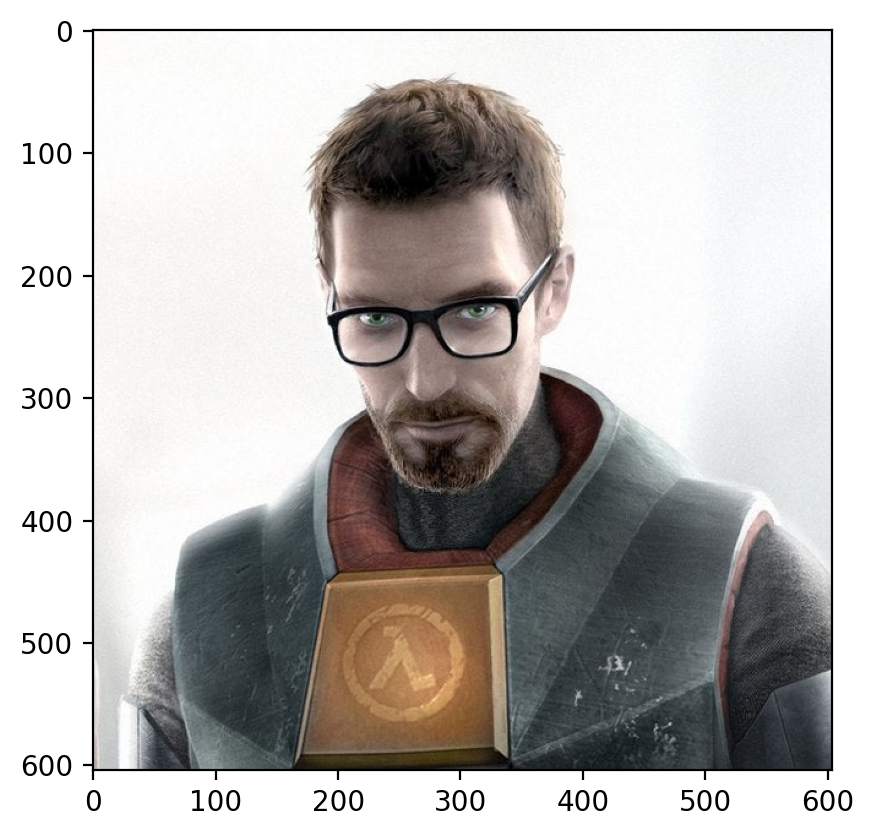

In [7]:
im = Image.open("../images/gordon_freeman.jpg")
plt.imshow(im)
plt.show()

Note that for a given value of $K$, the algorithm is representing the image using a palette of only $K$ colours. It should be emphasized that the use of K-means is not a particularly sophisticated approach to image segmentation, because it takes no account of the spatial proximity of different pixels.

In [8]:
im_array = np.asarray(im)
pixels = im_array.reshape(-1, 3)

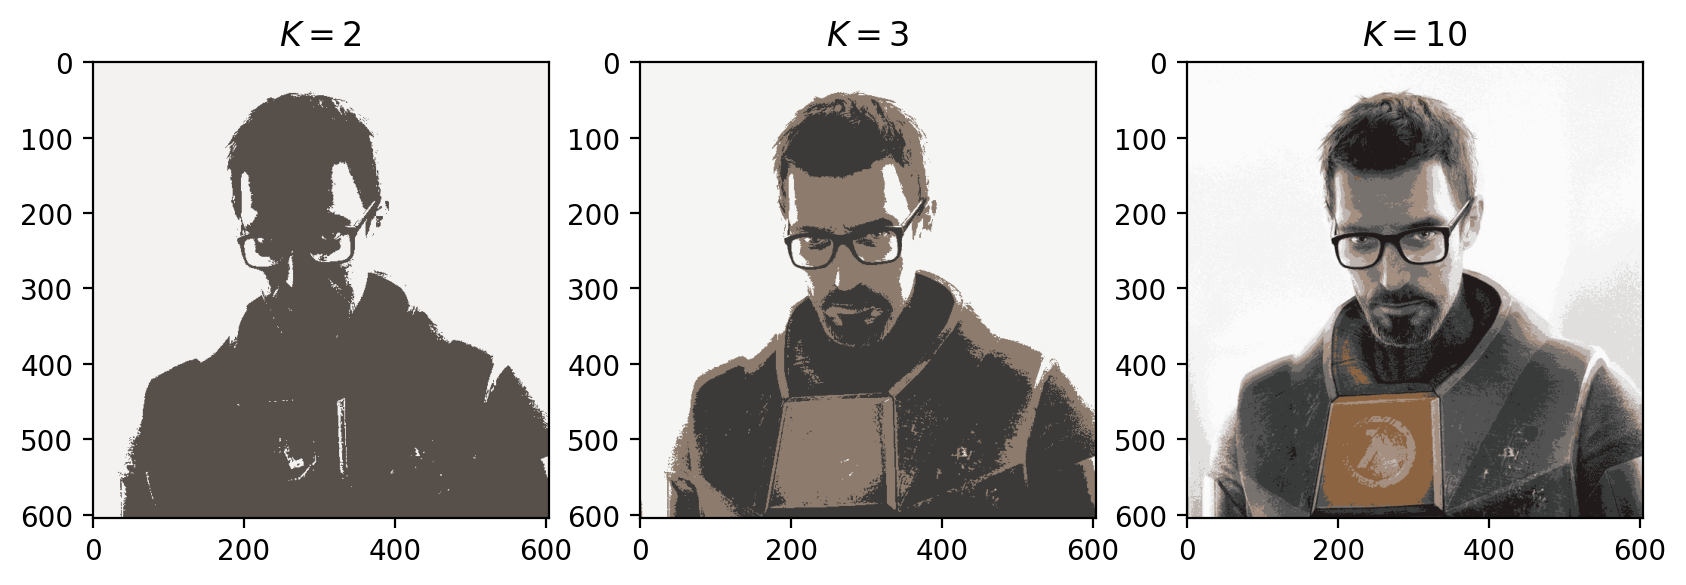

In [9]:
plt.figure(figsize=(10, 5))

for i, k in enumerate([2, 3, 10]):
    model = KMeans(k)
    model.fit(pixels)
    segments = model.predict(pixels)
    segmented_im = model.centers[segments].astype(int).reshape(im_array.shape)

    plt.subplot(1, 3, i + 1)
    plt.imshow(segmented_im)
    plt.title(f"$K={k}$")

## 9.2 Mixtures of Gaussians

In [Chapter 2](ch2_probability_distributions.ipynb) we discussed the Gaussian mixture model as a simple linear superposition of Gaussian components, leading to a richer class of multi-modal density models than the single Gaussian. Here we turn to a formulation of Gaussian mixtures in terms of discrete latent variables, which motivates the expectation-maximization algorithm.

The Gaussian mixture distribution can be written as a linear superposition of Gaussians in the form,

$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)
$$

Then, we introduce a $K$-dimensional binary random variable $\mathbf{z}$ having a $1$-of-$K$ representation. The marginal distribution over $\mathbf{z}$ is specified in terms of the mixing coefficients $\pi_k$, such that,

$$
p(z_k=1) = \pi_k
$$

Because $\mathbf{z}$ uses a $1$-of-$K$ representation, we can also write this distribution in the form

$$
p(\mathbf{z}) = \prod_{k=1}^K \pi_k^{z_k}
$$

The conditional distribution of $\mathbf{x}$ given a particular value for $\mathbf{z}$ is a Gaussian,

$$
p(\mathbf{x}|z_k=1) = \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)
$$

or

$$
p(\mathbf{x}|\mathbf{z}) = \prod_{k=1}^K \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)^{z_k}
$$

The joint distribution is given by $p(\mathbf{z})p(\mathbf{x}|\mathbf{z})$, and the marginal distribution of $\mathbf{x}$ is then obtained by summing the joint distribution over all possible states of $\mathbf{z}$ to give,

$$
p(\mathbf{x}) = \sum_{\mathbf{z}} p(\mathbf{z})p(\mathbf{x}|\mathbf{z}) = \sum_{\mathbf{z}} \prod_{k=1}^K \pi_k^{z_k} \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)^{z_k}
= \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)
$$

Since the summation over $\mathbf{z}$ actually consists of $K$ terms and the $k$-th term corresponds to $z_k$ equal to 1. Moreover, for the $k$-th term, the product will reduce to $\pi_k \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)$.

This equivalent formulation of the Gaussian mixture involving an explicit latent variable, allows to work with the joint distribution $p(\mathbf{x},\mathbf{z})$ instead of the marginal distribution $p(\mathbf{x})$, which leads to significant simplifications, through the introduction of the expectation-maximization (EM) algorithm.

Another quantity that plays an important role is the conditional probability $p(\mathbf{z}|\mathbf{x})$. We shall use $\gamma(z_k)$ to denote $p(z_k=1|\mathbf{x})$, whose value can be found
using Bayes theorem,

$$
\gamma(z_k) = p(z_k=1|\mathbf{x}) = \frac{p(z_k=1)p(\mathbf{x}|z_k=1)}{\sum_{j=1}^K p(z_j=1)p(\mathbf{x}|z_j=1)} 
= \frac{\pi_k\mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}|\boldsymbol\mu_j,\mathbf{\Sigma}_j)}
$$

which can also be viewed as the responsibility that component $k$ takes for *explaining* the observation $\mathbf{x}$.

### 9.2.1 Maximum likelihood

Suppose we are given a data set of observations $\{\mathbf{x}_1,\dots,\mathbf{x}_N\}$, and we wish to model the data using a mixture of Gaussians. We can formulate the data set as an $N \times D$ matrix $\mathbf{X}$. Similarly, the corresponding latent variables mey be denoted by an $N \times K$ matrix $\mathbf{Z}$. Assuming that data points are i.i.d., then the log of the likelihood function for the Gaussian mixture model is given by

$$
\ln p(\mathbf{X}|\boldsymbol\pi,\boldsymbol\mu,\mathbf{\Sigma}) = \sum_{n=1}^N \ln\Bigg\{ \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k) \Bigg\}
$$

Maximizing the log likelihood function for a Gaussian mixture model turns out to be a more complex problem than for the case of a single Gaussian. The difficulty arises from the presence of the summation over $k$ that appears inside the logarithm, so that the logarithm function no longer acts directly on the Gaussian. If we attempt to set the derivatives of the log likelihood to zero, we will no longer obtain a closed form solution.

> Keep in mind, that one approach is to apply gradient-based optimization, similar to Mixture Density Networks.

### 9.2.2 EM for Gaussian mixtures

An elegant and powerful method for finding maximum likelihood solutions for models with latent variables is called the expectation-maximization algorithm, or EM algorithm. We shall motivate the EM algorithm through a relatively informal treatment in the context of the Gaussian mixture model.

> Keep in mind that a more general treatment of EM exists that has broad applicability. Moreover, EM can be generalized to obtain the variational inference framework.

Lets start by setting the derivatives of log likelihood with respect to the means of the Gaussian components to zero, we obtain,

$$
\begin{aligned}
\frac{\partial}{\partial\boldsymbol\mu_k}\ln p(\mathbf{X}|\boldsymbol\pi,\boldsymbol\mu,\mathbf{Z}) = 0 &\Leftrightarrow
\sum_{n=1}^N \frac{\partial}{\partial\boldsymbol\mu_k} \ln\Bigg\{ \sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j) \Bigg\} = 0 \\
&\Leftrightarrow \sum_{n=1}^N \frac{1}{\sum_{k=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j)} \frac{\partial}{\partial\boldsymbol\mu_k} \sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j) = 0 \\
&\Leftrightarrow \sum_{n=1}^N \frac{1}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j)} \frac{\partial}{\partial\boldsymbol\mu_k} \pi_k \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_k,\mathbf{\Sigma}_k) = 0 \\
&\overset{(e^z)'=e^zz'}{\Leftrightarrow} -\sum_{n=1}^N \frac{\pi_k \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_k,\mathbf{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j)} \mathbf{\Sigma}_k(\mathbf{x}_n - \boldsymbol\mu_k) = 0 \\
&\Leftrightarrow - \sum_{n=1}^N \gamma(z_{nk}) \mathbf{\Sigma}_k(\mathbf{x}_n - \boldsymbol\mu_k) = 0 \\
&\overset{\times \mathbf{\Sigma}_k^{-1}}{\Leftrightarrow} - \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \boldsymbol\mu_k) = 0 \\
&\Leftrightarrow \sum_{n=1}^N \gamma(z_{nk})\boldsymbol\mu_k - \sum_{n=1}^N \gamma(z_{nk})\mathbf{x}_n = 0 \\
&\Leftrightarrow \boldsymbol\mu_k = \frac{1}{\sum_{n=1}^N \gamma(z_{nk})}\sum_{n=1}^N \gamma(z_{nk})\mathbf{x}_n
\end{aligned}
$$

> Note that the mean $\boldsymbol\mu_k$ for the $k$-th Gaussian component is obtained by taking a weighted mean of all of the points in the data set, in which the weighting factor for data point $\mathbf{x}_n$ is given by the posterior probability $\gamma(z_{nk})$ that component $k$ was responsible for generating $\mathbf{x}_n$.

Next, setting the derivative of the log likelihood with respect to $\mathbf{\Sigma}_k$ to zero, and making use of the result for the maximum likelihood solution for the covariance matrix of a single Gaussian, we obtain,

$$
\begin{aligned}
\frac{\partial}{\partial\mathbf{\Sigma}_k}\ln p(\mathbf{X}|\boldsymbol\pi,\boldsymbol\mu,\mathbf{Z}) = 0 &\Leftrightarrow
\sum_{n=1}^N \frac{\partial}{\partial\mathbf{\Sigma}_k} \ln\Bigg\{ \sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j) \Bigg\} = 0 \\
&\Leftrightarrow \sum_{n=1}^N \frac{1}{\sum_{k=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j)} \frac{\partial}{\partial\mathbf{\Sigma}_k} \sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j) = 0 \\
&\Leftrightarrow \sum_{n=1}^N \frac{1}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j)} \frac{\partial}{\partial\mathbf{\Sigma}_k} \pi_k \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_k,\mathbf{\Sigma}_k) = 0 \\
&\overset{(e^z)'=e^zz'}{\Leftrightarrow} -\sum_{n=1}^N \frac{\pi_k \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_k,\mathbf{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j)} \Bigg( \mathbf{\Sigma}_k - (\mathbf{x}_n - \boldsymbol\mu_k)(\mathbf{x}_n - \boldsymbol\mu_k)^T \Bigg) = 0 \\
&\Leftrightarrow -\sum_{n=1}^N \gamma(z_{nk}) \Bigg( \mathbf{\Sigma}_k - (\mathbf{x}_n - \boldsymbol\mu_k)(\mathbf{x}_n - \boldsymbol\mu_k)^T \Bigg) = 0 \\
&\Leftrightarrow \sum_{n=1}^N \gamma(z_{nk})(\mathbf{x}_n - \boldsymbol\mu_k)(\mathbf{x}_n - \boldsymbol\mu_k)^T - \sum_{n=1}^N \gamma(z_{nk})\mathbf{\Sigma}_k = 0 \\
&\Leftrightarrow \mathbf{\Sigma}_k = \frac{1}{\sum_{n=1}^N \gamma(z_{nk})} \sum_{n=1}^N \gamma(z_{nk})(\mathbf{x}_n - \boldsymbol\mu_k)(\mathbf{x}_n - \boldsymbol\mu_k)^T \\
\end{aligned}
$$

which has the same form as the corresponding result for a single Gaussian, but data points are weighted by the corresponding posterior probability.

Finally, setting the derivative of the log likelihood with respect to $\pi_k$ to zero, requires for the constraint $(9.9)$ to hold (mixing coefficients should sum to one). This can be achieved using a Lagrange multiplier and maximizing, which gives,

$$
p_k = \frac{N_k}{N}
$$

Note that these results do not constitute a closed-form solution for the parameters of the mixture model because the responsibilities $\gamma(z_{nk})$ depend on those parameters in a complex way through $(9.13)$. However, these results suggest a simple iterative scheme for finding the solution, which turns out to be an instance of the EM algorithm for the particular case of the Gaussian mixture model.

**EM for Gaussian Mixtures**

We first choose initial values for the means, covariances, and mixing coefficients. Then we alternate between two updates, namely the E-step and the M-step. In the expectation (E) step, we use the current values for the parameters to evaluate the posterior probabilities or responsibilities. Then, in the maximization (M) step, we use these probabilities to to re-estimate the means, covariances, and mixing coefficients. Note that for the M-step, we first evaluate the new means, and then use them to find the covariances.

1. Initialize the means $\boldsymbol\mu_k$, covariances $\mathbf{\Sigma}_k$ and mixing coefficients $\pi_k$, and evaluate the log-likelihood.

2. **E-step:** Evaluate the responsibilities using the current parameter values

$$
\gamma(z_{nk}) = \frac{\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_k,\mathbf{\Sigma}_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_j,\mathbf{\Sigma}_j)}
$$

3. **M-step:** Re-estimatea the parameters using the current responsibilities

$$
\begin{aligned}
\boldsymbol\mu_k^{new} &= \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n \\
\mathbf{\Sigma}_k^{new} &= \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \boldsymbol\mu_k^{new})(\mathbf{x}_n - \boldsymbol\mu_k^{new})^T \\
\pi_k^{new} &= \frac{N_k}{N} \\
N_k &= \sum_{n=1}^N\gamma(z_{nk})
\end{aligned}
$$

4. Evaluate the log-likelihood $\ln p(\mathbf{X}|\boldsymbol\mu,\mathbf{\Sigma},\boldsymbol\pi)$

5. Repeat until convergence, either of the parameters or the log-likelihood.



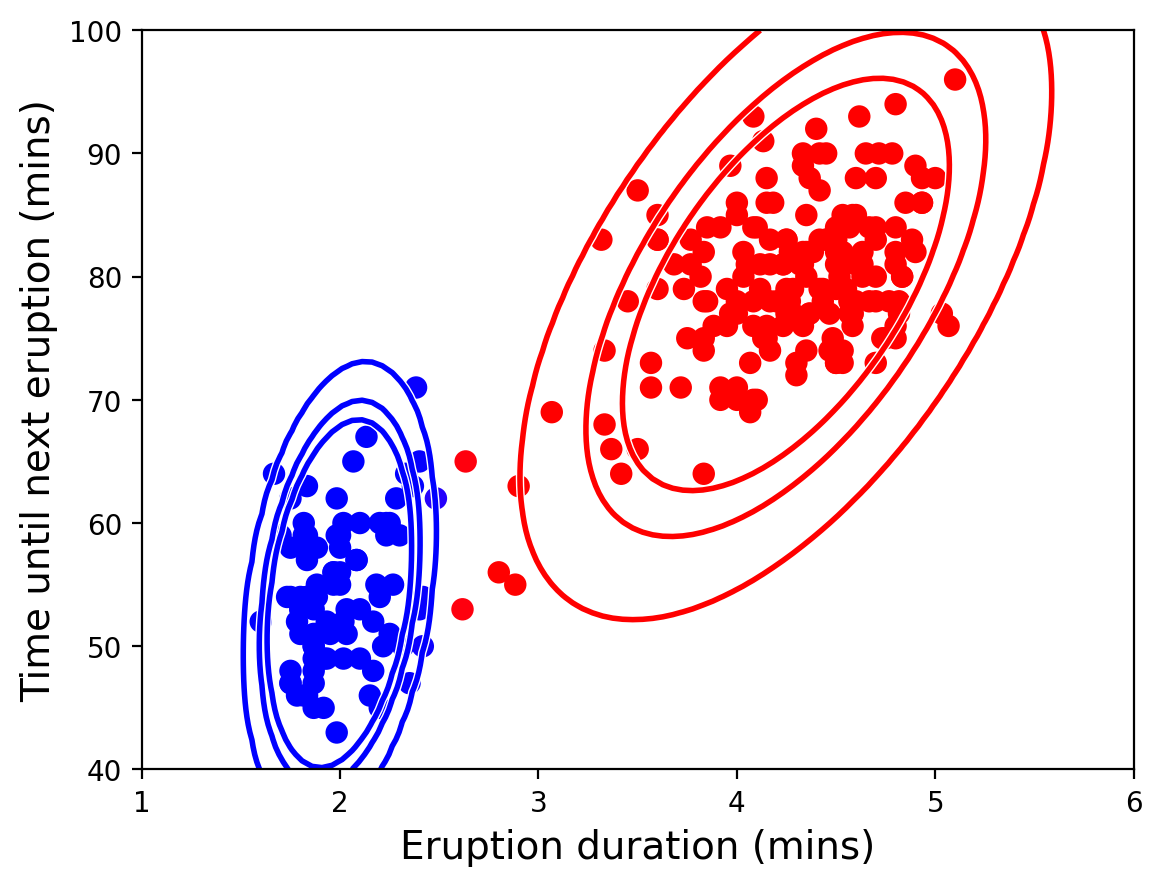

In [74]:
model = MultivariateGaussianMixture(n_components=2)
model.ml(old_faithful)

x, y = np.meshgrid(np.linspace(1, 6, 100), np.linspace(40, 100, 100))

colors = [
    (a / np.linalg.norm([a, b]), 0, b / np.linalg.norm([a, b]))
    for a, b in zip(*[w * np.diag(c.pdf(old_faithful.T)) for w, c in zip(model._coefficients, model._components)])
]

plt.scatter(old_faithful[:, :1], old_faithful[:, 1:2], c=colors, facecolors="none", s=50)
for i, component in enumerate(model._components):
    x_new = np.array([x, y]).reshape(2, -1)
    p = np.diag(component.pdf(x_new)).reshape(100, 100)
    plt.contour(x, y, p, linewidths=3, colors=["white"], levels=[0.001, 0.005, 0.01])
    plt.contour(x, y, p, linewidths=2, colors=["red" if i == 0 else "blue"], levels=[0.001, 0.005, 0.01])
plt.xlim(1, 6)
plt.ylim(40, 100)
plt.xlabel("Eruption duration (mins)", fontsize=14)
plt.ylabel("Time until next eruption (mins)", fontsize=14)
plt.show()

> Note that EM takes much more iterations to converge compared to $K$-means, and each iteration requires significantly more computation. Is therefore common to run the $K$-means algorithm in order to find a suitable initialization for the means of a Gaussian mixture model that is subsequently adapted using EM. The covariance matrices, can be initialized to the sample covariances of the clusters found by $K$-means, and the mixing coefficients to the fraction of data points assigned to the respective clusters.

## 9.3 An Alternative View of EM

The goal of EM is to find the maximum likelihood solution for models having latent variables. In a more general form, the log likelihood is given by

$$
\ln p(\mathbf{X}|\boldsymbol\theta) = \ln \Bigg\{ \sum_{\mathbf{z}} p(\mathbf{X},\mathbf{Z}|\boldsymbol\theta) \Bigg\}
$$

where $\mathbf{X}$ denotes the set of all observed data, $\mathbf{Z}$ denotes the set of all latent variables, and $\boldsymbol\theta$ denotes the set of all model parameters. Since the latent variables appear inside the logarithm, the presence of the sum prevents the logarithm from acting directly on the joint distribution, resulting in complicated expressions. Given that the latent variables are not known, our state of knowledge about their values $\mathbf{Z}$ is only given by their posterior distribution $p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta)$. 

According to EM, given a current estimate for the parameters $\boldsymbol\theta^{\texttt{old}}$, then a pair of succesive E and M steps gives rise to a revised estimate $\boldsymbol\theta^{\texttt{new}}$. In the E-step, we use the current estimate $\boldsymbol\theta^{\texttt{old}}$ to define the posterior distribution of the latent variables given by $p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}})$. Then, we use the posterior to find the expectation of the complete-data log-likelihood evaluated for some general parameter value $\boldsymbol\theta$,

$$
\mathcal{Q}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}}) = \sum_{\mathbf{z}} p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}}) \ln p(\mathbf{X},\mathbf{Z}|\boldsymbol\theta)
$$

In the M-step, we determine the revised parameter estimate $\boldsymbol\theta^{\texttt{new}}$ by maximizing the function,

$$
\boldsymbol\theta^{\texttt{new}} = \text{argmax}_{\boldsymbol\theta} \mathcal{Q}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}})
$$

Note that in the definition of $\mathcal{Q}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}})$, the logarithm acts directly on the joint distribution and so the maximization is tractable. The general EM is summarized below:

> The General EM Algorithm
>
> Given a joint distribution $p(\mathbf{X},\mathbf{Z}|\boldsymbol\theta)$ over observed variables $\mathbf{X}$ and latent (unobserved) variables $\mathbf{Z}$, governed by  unknown parameters $\boldsymbol\theta$, the goal is to maximize the likelihood function $p(\mathbf{X}|\boldsymbol\theta)$ with respect to $\boldsymbol\theta$.
>
>1. Choose an initial value for the parameters $\boldsymbol\theta^{\texttt{old}}$.
>2. **E-step:** Evaluate $p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}})$.
>3. **M-step:** Evaluate $\boldsymbol\theta^{\texttt{new}}$ given by
>$$
>\boldsymbol\theta^{\texttt{new}} = \text{argmax}_{\boldsymbol\theta} \mathcal{Q}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}})
>$$
>4. Check for convergence of either the log likelihood or the parameter values. If the convergence criterion is not satisfied, the let
>$$
>\boldsymbol\theta^{\texttt{old}} \leftarrow \boldsymbol\theta^{\texttt{new}}
>$$
>and return to step 2.

The EM algorithm may also be used to find MAP solutions for models in which a prior $p(\boldsymbol\theta)$ is defined over the parameters. In such cases, the E-step remains identical, whereas in the M-step the quantity to be maximized is given by $\mathcal{Q}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}}) + \ln p(\boldsymbol\theta)$. To see that, according to Bayes’ Theorem, we have that,

$$
p(\boldsymbol\theta|\mathbf{X}) = p(\mathbf{X}|\boldsymbol\theta)p(\boldsymbol\theta)
$$

Furthermore utilizing Eq. $(9.29)$, we obtain,

$$
\ln p(\boldsymbol\theta|\mathbf{X}) = \ln \Bigg\{ \Big[ \sum_{\mathbf{z}} p(\mathbf{X},\mathbf{Z}|\boldsymbol\theta) \Big] p(\boldsymbol\theta) \Bigg\}
$$

Therefore, in the E-step, we still need to calculate the posterior $p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}})$, and then for the M-step, by analogy to Eq $(9.30)$, we obtain,

$$
\begin{aligned}
\mathcal{Q}_{MAP}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}}) &= 
\sum_{\mathbf{z}} p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}}) \ln \Big[ p(\mathbf{X},\mathbf{Z}|\boldsymbol\theta)p(\boldsymbol\theta) \Big] \\
&= \sum_{\mathbf{z}} p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}}) \Big[ \ln p(\mathbf{X},\mathbf{Z}|\boldsymbol\theta) + \ln p(\boldsymbol\theta) \Big] \\
&= \sum_{\mathbf{z}} p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}}) \ln p(\mathbf{X},\mathbf{Z}|\boldsymbol\theta) + 
\sum_{\mathbf{z}} p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}}) \ln p(\boldsymbol\theta) \\
&= \mathcal{Q}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}}) + \ln p(\boldsymbol\theta) \sum_{\mathbf{z}} p(\mathbf{Z}|\mathbf{X},\boldsymbol\theta^{\texttt{old}}) \\
&= \mathcal{Q}(\boldsymbol\theta, \boldsymbol\theta^{\texttt{old}}) + \ln p(\boldsymbol\theta)
\end{aligned}
$$

> Note that EM can also be applied when the unobserved variables correspond to missing values in the data set. The distribution of the observed values is obtained by taking the joint distribution of all the variables and the marginalizing over the missing ones. However, keep in mind this is a valid approach only if the data values are *missing at random*, meaning that the mechanism causing the values to be missing does not depend on the unobserved values. For instance, a sensor may fail to return a value whenever the quantity it is measuring exceeds some threshold.

### 9.3.2 Relation to $K$-Means

The $K$-means algorithm performs a hard-assignment of data points to clusters, and thus, each data point is assosiated with one cluster. The EM algorithm makes *soft* assignment based on the posterior probabilities, that is, each data point softly belongs to a mixture of clusters. In fact we can derive $K$-means as a particular limit of the EM for Gaussian mixtures.

Consider a Gaussian mixture model in which covariance matrices of the mixture components are given by $\epsilon\mathbf{I}$, where $\epsilon$ is a variance paramater shared across all of the components, so that each component is a Gaussian of the form,

$$
p(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k) = \frac{1}{(2\pi\epsilon)^{M/2}}\exp\Big\{ -\frac{1}{2\epsilon}||\mathbf{x} - \boldsymbol\mu_k||^2 \Big\}
$$

According the EM algorithm for a mixture of $K$ Gaussians, the responsibilies are given by

$$
\gamma(z_{nk}) = \frac{\pi_k\exp\big\{-\frac{ ||\mathbf{x} - \boldsymbol\mu_k||^2}{2\epsilon}\big\}}{\sum_j\pi_j\exp\big\{-\frac{ ||\mathbf{x} - \boldsymbol\mu_j||^2}{2\epsilon}\big\}}
$$

<!-- In the limit $\epsilon \mapsto 0$, the term in the denominator for which $||\mathbf{x} - \boldsymbol\mu_j||^2$ is the smallest, will go to zero -->


### 9.3.3 Mixtures of Bernoulli distributions

### 9.3.4 EM for Bayesian linear regression

## 9.4 The EM Algorithm in General